Neste notebook serão realizadas previsões para os anos de 2023 e 2024. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from models import build_baseline, train_model_using_cross_val, make_predictions
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)


Inicialmente iremos treinar os modelo usando os dados até 2023 para prever o ano de 2023.

In [2]:
STATE = 'MG'
TEST_YEAR = 2023

In [3]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
enso = prep.load_enso_data()

# generate the samples to train and test based on the regional data 
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR)

In [4]:
X_train.shape

(801, 52, 5)

In [5]:
y_train.shape

(801, 52)

Definição da custom loss: 

In [6]:
def custom_loss(y_true, y_pred):
    '''
    Test of a custom loss function
    '''
    first_log = tf.math.log(y_pred + 1.0)
    second_log = tf.math.log(y_true + 1.0)

    sum_values = abs(tf.reduce_sum(y_pred) - tf.reduce_sum(y_true))

    peak_mag = abs(tf.reduce_max(y_pred) - tf.reduce_max(y_true))

    peak_pos = abs(tf.argmax(y_pred) - tf.argmax(y_true))

    sum_values = tf.cast(sum_values, tf.float32)
    peak_mag = tf.cast(peak_mag, tf.float32)
    peak_pos = tf.cast(peak_pos, tf.float32)

    return tf.reduce_mean(tf.square(first_log - second_log))  + 0.05*sum_values + 0.05*peak_mag + 0.05*peak_pos


In [7]:
LOSS = custom_loss

In [8]:
batch_size = 4
model = build_baseline( hidden=64, features=5, predict_n=52, look_back=52, loss=LOSS, 
                  stateful = False, batch_size = batch_size,  optimizer = Adam(learning_rate=0.001))

model 

/opt/homebrew/Caskroom/miniforge/base/envs/train_lstm/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (4, 52, 5)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (4, 52, 64)            │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 52, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (4, 64)                │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (4, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 52)                │         3,380 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,324 (212.20 KB)

 Trainable params: 54,324 (212.20 KB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional, built=True>

In [9]:
%%time 
model = train_model_using_cross_val(model, X_train, y_train, n_splits=4, epochs = 150,
                                verbose = 0,
                                batch_size = batch_size, 
                                monitor = 'val_loss',
                                min_delta = 0,
                                patience = 15)

Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
CPU times: user 3min 28s, sys: 12.7 s, total: 3min 41s
Wall time: 3min 32s


In [10]:
# Retreinando com os dados do estado e aplicando para o ano de teste
df_w = prep.aggregate_data(df)

data = df_w.merge(enso[['enso']], left_index = True, right_index = True)

X_train, y_train, norm_values = prep.get_train_data(data.loc[data.year < TEST_YEAR])

X_test, y_test = prep.get_test_data(norm_values,data, year = TEST_YEAR)

In [11]:
X_train.shape

(9, 52, 5)

In [12]:
model.compile(loss=LOSS, optimizer = Adam(learning_rate = 0.0001), metrics=["accuracy", "mape", "mse"])

TB_callback = TensorBoard(
            log_dir="./tensorboard",
            histogram_freq=0,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            # embeddings_freq=10
        )

hist = model.fit(
            X_train,
            y_train,
            batch_size=1,
            epochs=25,
            verbose=0,
            callbacks=[TB_callback]
        )

# save the model
model.save(f'saved_models/model_{STATE}_{TEST_YEAR-1}_cl.keras')


Aplicando o modelo para 2023:

In [13]:
df_preds_23 = make_predictions(model, X_test, norm_values, dates = prep.gen_forecast_dates(TEST_YEAR))

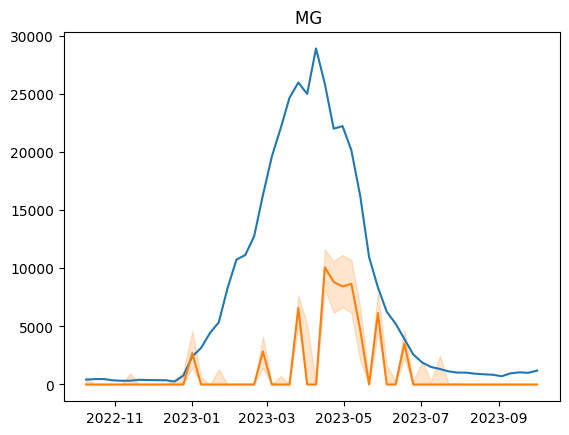

In [14]:
fig, ax = plt.subplots()

ax.plot(df_w.loc[df_w.year == TEST_YEAR].casos, label = 'Data')

ax.plot(df_preds_23.dates, df_preds_23.preds, label = 'preds')

ax.fill_between( df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'MG ')

plt.show()

Para fazer as previsões para 2024 iremos retreinar o modelo usando os dados de 2023: 

Devo retreinar tudo novamente mas usando o mesmo modelo como start já que a normalização dos dados mudam?? 

In [15]:
TEST_YEAR = 2024

In [16]:
#regional samples
X_train_reg, y_train_reg = prep.generate_regional_train_samples(df, enso, TEST_YEAR, min_year = 2023)

# state samples
df_w = prep.aggregate_data(df)

data = df_w.merge(enso[['enso']], left_index = True, right_index = True)

X_train_state, y_train_state, norm_values = prep.get_train_data(data.loc[data.year < TEST_YEAR], min_year = 2023)

X_test, y_test = prep.get_test_data(norm_values,data, year = TEST_YEAR)

X_train = np.append(X_train_reg, X_train_state, axis = 0)

y_train = np.append(y_train_reg, y_train_state, axis = 0)


In [17]:
X_train.shape

(90, 52, 5)

Retrain the model and save:

In [18]:
model.compile(loss=LOSS, optimizer = Adam(learning_rate = 0.0001), metrics=["accuracy", "mape", "mse"])

TB_callback = TensorBoard(
            log_dir="./tensorboard",
            histogram_freq=0,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            # embeddings_freq=10
        )

hist = model.fit(
            X_train,
            y_train,
            batch_size=4,
            epochs=100,
            verbose=0,
            callbacks=[TB_callback, EarlyStopping(monitor='loss', min_delta=0, patience=20)]
        )

# save the model
model.save(f'saved_models/model_{STATE}_{TEST_YEAR-1}_notebook.keras')


Aplicando o modelo para 2024:

In [19]:
df_preds_24 = make_predictions(model, X_test, norm_values, dates = prep.gen_forecast_dates(TEST_YEAR))

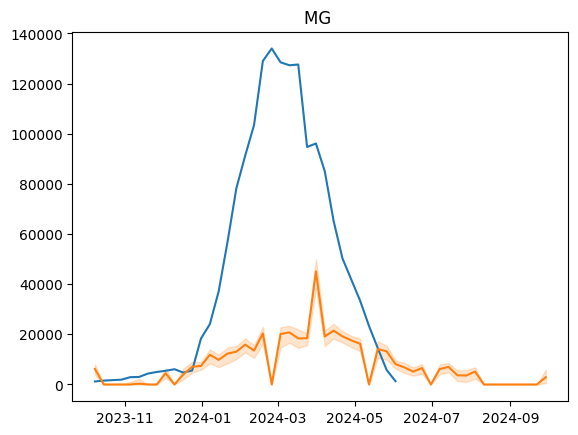

In [20]:
fig, ax = plt.subplots()

ax.plot(df_w.loc[df_w.year == TEST_YEAR].casos, label = 'Data')

ax.plot(df_preds_24.dates, df_preds_24.preds, label = 'preds')

ax.fill_between( df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax.set_title(f'MG ')

plt.show()

Colocando as predições lado a lado e comparando com o valor de baseline salvo: 

In [28]:
df_preds_23_base = pd.read_csv('./predictions/preds_MG_2023_baseline.csv', index_col = 'Unnamed: 0')

df_preds_23_base.dates = pd.to_datetime(df_preds_23_base.dates)

df_preds_24_base = pd.read_csv('./predictions/preds_MG_2024_baseline.csv',  index_col = 'Unnamed: 0')

df_preds_24_base.dates = pd.to_datetime(df_preds_24_base.dates)

df_preds_23_base.head()

,dates,lower,preds,upper
0,2022-10-09,0.000000,0.000000,0.000000
1,2022-10-16,0.000000,0.000000,0.000000
2,2022-10-23,0.000000,0.000000,0.000000
3,2022-10-30,0.000000,0.000000,0.000000
4,2022-11-06,609.734634,1486.289477,2046.079896


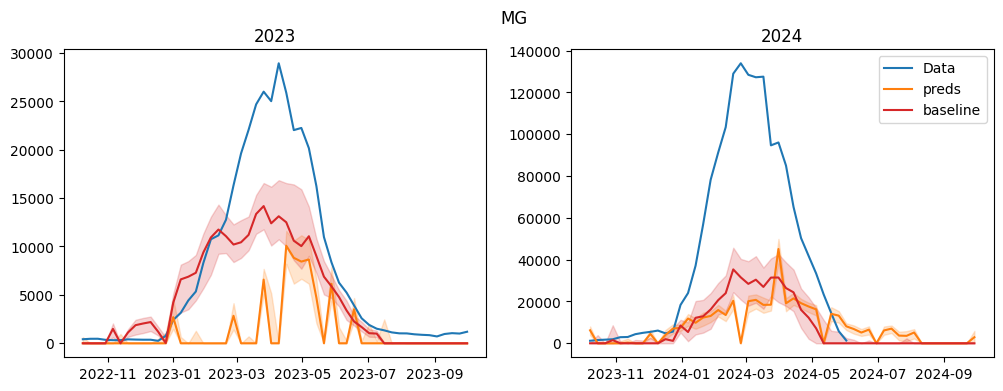

In [29]:
fig, ax = plt.subplots(1,2, figsize = (12, 4))

ax[0].plot(df_w.loc[df_w.year == 2023].casos, label = 'Data')

ax[0].plot(df_preds_23.dates, df_preds_23.preds, label = 'preds')

ax[0].fill_between( df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax[0].plot(df_preds_23_base.dates, df_preds_23_base.preds, label = 'baseline', color = 'tab:red')

ax[0].fill_between( df_preds_23_base.dates, df_preds_23_base.lower, df_preds_23_base.upper, color = 'tab:red', alpha = 0.2)

ax[0].set_title('2023')

ax[1].plot(df_w.loc[df_w.year == 2024].casos, label = 'Data')

ax[1].plot(df_preds_24.dates, df_preds_24.preds, label = 'preds')

ax[1].fill_between( df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax[1].plot(df_preds_24_base.dates, df_preds_24_base.preds, label = 'baseline', color = 'tab:red')

ax[1].fill_between( df_preds_24_base.dates, df_preds_24_base.lower, df_preds_24_base.upper, color = 'tab:red', alpha = 0.2)

ax[1].set_title('2024')

ax[1].legend()

plt.suptitle('MG')

plt.show()

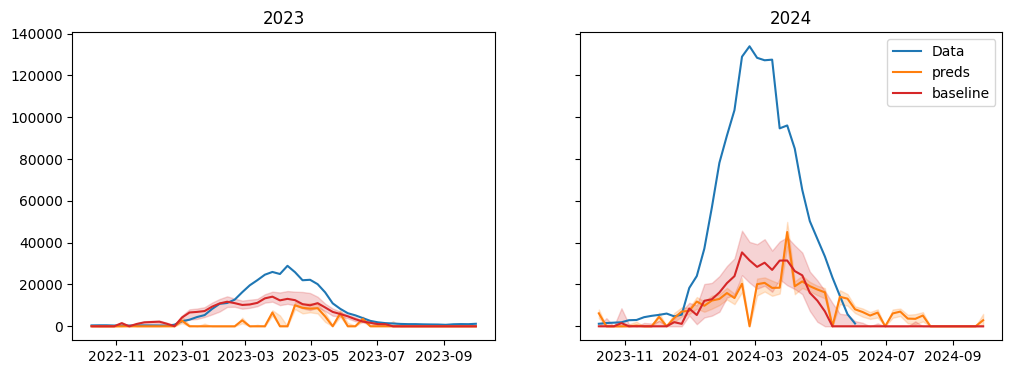

In [30]:
fig, ax = plt.subplots(1,2, figsize = (12, 4), sharey = True)

ax[0].plot(df_w.loc[df_w.year == 2023].casos, label = 'Data')

ax[0].plot(df_preds_23.dates, df_preds_23.preds, label = 'preds')

ax[0].fill_between( df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax[0].plot(df_preds_23_base.dates, df_preds_23_base.preds, label = 'baseline', color = 'tab:red')

ax[0].fill_between( df_preds_23_base.dates, df_preds_23_base.lower, df_preds_23_base.upper, color = 'tab:red', alpha = 0.2)

ax[0].set_title('2023')

ax[1].plot(df_w.loc[df_w.year == 2024].casos, label = 'Data')

ax[1].plot(df_preds_24.dates, df_preds_24.preds, label = 'preds')

ax[1].fill_between( df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax[1].plot(df_preds_24_base.dates, df_preds_24_base.preds, label = 'baseline', color = 'tab:red')

ax[1].fill_between( df_preds_24_base.dates, df_preds_24_base.lower, df_preds_24_base.upper, color = 'tab:red', alpha = 0.2)

ax[1].set_title('2024')

ax[1].legend()

plt.show()

In [31]:
df_preds_23.to_csv('./predictions/preds_MG_2023_cl.csv')

df_preds_24.to_csv('./predictions/preds_MG_2024_cl.csv')